In [2]:
# Copyright 2022 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate some reference images & gradients.

In [3]:
#@title: Imports
# Train a whole image, see how that progresses for reference.
# Maybe capture first training step as something... ?
import math
import os
import gc
import time
from pathlib import Path
import mediapy
import numpy as np
import torch
from gsplat import project_gaussians
from gsplat import rasterize_gaussians
from gsplat import spherical_harmonics

import matplotlib.pyplot as plt

from PIL import Image

from safetensors.torch import save_file
from safetensors import safe_open

import dataclasses

In [18]:
g_device = torch.device("cuda:0")
DEFAULT_TILE_SIZE = 16
SH_DEGREE = 1
SH_COUNT = (SH_DEGREE + 1) ** 2


In [19]:
# Helper functions
@dataclasses.dataclass(frozen=True)
class Camera:
    viewmat: torch.Tensor
    focal: float
    w: int
    h: int
    background: torch.Tensor

def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor.to("cuda:0")

def fov_to_focal(fov: float, img_size: int) -> float: 
    return 0.5 * float(img_size) / math.tan(0.5 * fov)

def basic_camera(w: int, h: int) -> Camera:
    background = torch.zeros(3, device=g_device)
    fov_x = math.pi / 2.0
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=g_device,
    )
    focal = fov_to_focal(fov_x, w)
    return Camera(viewmat=viewmat, w=w, h=h, focal=focal, background=background)

In [20]:
crab_img = image_path_to_tensor("./crab.png")

def execute_test(means, log_scales, quats, coeffs, opacities, name: str):
    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True

    H, W, _ = crab_img.shape
    cam = basic_camera(W, H)

    xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        cam.viewmat,
        cam.focal,
        cam.focal,
        cam.w / 2,
        cam.h / 2,
        cam.h,
        cam.w,
        DEFAULT_TILE_SIZE,
        0.01
    )
    
    viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(SH_DEGREE, viewdirs, coeffs) + 0.5
    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        H,
        W,
        DEFAULT_TILE_SIZE,
        cam.background,
    )[..., :3]
    out_img.retain_grad()
    conics.retain_grad()
    xys.retain_grad()
    mediapy.show_image((out_img.detach().cpu().numpy() * 255.0).astype(np.uint8), width=W*4, height=H*4)

    loss = ((out_img - crab_img) ** 2).mean()
    loss.backward()
    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
        "depths": depths,
        "xys": xys,
        "radii": radii,
        "conics": conics,
        "out_img": out_img,

        "v_xy": xys.grad,
        "v_conics": conics.grad,
        "v_means": means.grad,
        "v_scales": log_scales.grad,
        "v_coeffs": coeffs.grad,
        "v_quats": quats.grad,
        "v_opacities": opacities.grad,
        "v_out_img": out_img.grad,
    }
    save_file(tensors, f"./{name}.safetensors")

""

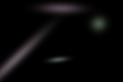

In [21]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(14)
    num_points = 4
    means = 10.5 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=g_device) * 2.5).log()
    coeffs = (torch.rand(num_points, SH_COUNT, 3, device=g_device) - 0.5) * 0.5
    
    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device) * 0.5 + 0.5
    execute_test(means, log_scales, quats, coeffs, opacities, "tiny_case")

test_case()

""

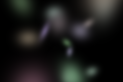

In [8]:

# Simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(3)
    num_points = 16
    means = 10.0 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = torch.rand(num_points, 3, device=g_device).log() * 0.5
    coeffs = (torch.rand(num_points, SH_COUNT, 3, device=g_device) - 0.5) * 0.5

    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device) * 0.5 + 0.5
    execute_test(means, log_scales, quats, coeffs, opacities, "basic_case")

test_case()


""

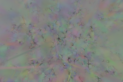

In [9]:

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(4)
    num_points = 76873
    means = 2000.0 * (torch.rand(num_points, 3, device=g_device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=g_device) * 15.0 + 0.05).log()
    coeffs = (torch.rand(num_points, SH_COUNT, 3, device=g_device) - 0.5) * 0.5
    
    u = torch.rand(num_points, 1, device=g_device)
    v = torch.rand(num_points, 1, device=g_device)
    w = torch.rand(num_points, 1, device=g_device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=g_device)
    execute_test(means, log_scales, quats, coeffs, opacities, "mix_case")

test_case()

In [10]:
def load_bench_tensors(point_frac: float, mean_mult: float, grad: bool):
    with safe_open("./bench_data.safetensors", framework="pt", device="cpu") as f:
        means: torch.Tensor = f.get_tensor("means")
        num_points = int(means.shape[0] * point_frac)
        means = means[0:num_points, ...] * mean_mult
        log_scales: torch.Tensor = f.get_tensor("scales")[0:num_points, ...]
        coeffs: torch.Tensor = f.get_tensor("coeffs")[0:num_points, ...]
        quats: torch.Tensor = f.get_tensor("quats")[0:num_points, ...]
        opacities: torch.Tensor = f.get_tensor("opacities")[0:num_points, ...]

    means = means.to(device=g_device).detach()
    log_scales = log_scales.to(device=g_device).detach()
    coeffs = coeffs.to(device=g_device).detach()
    quats = quats.to(device=g_device).detach()
    opacities = opacities.to(device=g_device).detach()

    means.requires_grad = grad
    log_scales.requires_grad = grad
    coeffs.requires_grad = grad
    quats.requires_grad = grad
    opacities.requires_grad = grad

    return means, log_scales, coeffs, quats, opacities

def test_render():
    means, log_scales, coeffs, quats, opacities = load_bench_tensors(1.1, 1.0, False)
    w, h = (512, 512)
    cam = basic_camera(w, h)
    xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        cam.viewmat,
        cam.focal,
        cam.focal,
        cam.w / 2,
        cam.h / 2,
        cam.h,
        cam.w,
        DEFAULT_TILE_SIZE,
        0.01
    )
    viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        cam.w,
        cam.h,
        DEFAULT_TILE_SIZE,
        cam.background,
    )[..., :3]
    plt.imshow(out_img.detach().cpu())

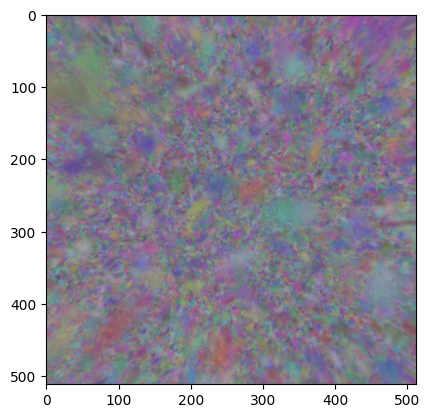

In [11]:
test_render()

In [12]:

BENCH_DENSITIES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
DENSE_MULT = 0.25

TARGET_SAMPLE_COUNT = 40
INTERNAL_ITERS = 4

def bench_general(point_frac: float, mean_mult: float, w: int, h: int, calc_grads: bool):
    # Generate camera
    cam = basic_camera(w, h)
    means, log_scales, coeffs, quats, opacities = load_bench_tensors(point_frac, mean_mult, calc_grads)

    def internal_iter():
        xys, depths, radii, conics, _comp, num_tiles_hit, _cov3d = project_gaussians(
            means,
            log_scales.exp(),
            1,
            quats,
            cam.viewmat,
            cam.focal,
            cam.focal,
            cam.w / 2,
            cam.h / 2,
            cam.h,
            cam.w,
            DEFAULT_TILE_SIZE,
            0.01
        )
        viewdirs = means - cam.viewmat[:3, 3]  # (N, 3)
        colors = spherical_harmonics(0, viewdirs, coeffs) + 0.5
        out_img = rasterize_gaussians(
            xys,
            depths,
            radii,
            conics,
            num_tiles_hit,
            colors,
            torch.sigmoid(opacities[:, None]),
            cam.h,
            cam.w,
            DEFAULT_TILE_SIZE,
            cam.background,
        )

        if calc_grads:
            xys.retain_grad()
            loss = out_img.mean()
            loss.backward()

    def measure_iter():
        start_time = time.perf_counter()
        for _ in range(INTERNAL_ITERS):
            internal_iter()
        torch.cuda.synchronize(g_device)
        bench_time = time.perf_counter() - start_time
        return bench_time
    
    times = [measure_iter() for _ in range(TARGET_SAMPLE_COUNT)]
    ret = np.median(times)
    print(f"bench_times: {ret}")
    return ret

In [13]:
gc.collect()

bench_times = {}

for grad in [False, True]:
    name = "fwd" if not grad else "bwd"
    print(f"{name} base")
    bench_times[f"{name}_base"] = [bench_general(dens, 1.0, 512, 512, grad) for dens in BENCH_DENSITIES]
    print(f"{name} dense")
    bench_times[f"{name}_dense"] = [bench_general(dens, DENSE_MULT, 512, 512, grad) for dens in BENCH_DENSITIES]
    print(f"{name} hd")
    bench_times[f"{name}_hd"] = [bench_general(dens, 1.0, 1024, 1024, grad) for dens in BENCH_DENSITIES]

fwd base
bench_times: 0.004979099999999903
bench_times: 0.005119950000000095
bench_times: 0.005329449999999625
bench_times: 0.005716249999998979
bench_times: 0.006259800000000482
bench_times: 0.006989799999999491
bench_times: 0.00784444999999856
bench_times: 0.008882949999998502
bench_times: 0.009597899999999271
bench_times: 0.010574950000000527
fwd dense
bench_times: 0.005000899999998865
bench_times: 0.005637100000001283
bench_times: 0.005604449999999872
bench_times: 0.006045150000000277
bench_times: 0.006799499999999625
bench_times: 0.007990200000000058
bench_times: 0.009840299999998692
bench_times: 0.011779399999999995
bench_times: 0.013923700000002981
bench_times: 0.015700799999999404
fwd hd
bench_times: 0.005010499999999141
bench_times: 0.0056600000000006645
bench_times: 0.0059813999999995815
bench_times: 0.006883950000000638
bench_times: 0.0072715999999992675
bench_times: 0.008368950000001263
bench_times: 0.009808799999998286
bench_times: 0.010708099999998666
bench_times: 0.01224

In [14]:
bench_times

{'fwd_base': [0.004979099999999903,
  0.005119950000000095,
  0.005329449999999625,
  0.005716249999998979,
  0.006259800000000482,
  0.006989799999999491,
  0.00784444999999856,
  0.008882949999998502,
  0.009597899999999271,
  0.010574950000000527],
 'fwd_dense': [0.005000899999998865,
  0.005637100000001283,
  0.005604449999999872,
  0.006045150000000277,
  0.006799499999999625,
  0.007990200000000058,
  0.009840299999998692,
  0.011779399999999995,
  0.013923700000002981,
  0.015700799999999404],
 'fwd_hd': [0.005010499999999141,
  0.0056600000000006645,
  0.0059813999999995815,
  0.006883950000000638,
  0.0072715999999992675,
  0.008368950000001263,
  0.009808799999998286,
  0.010708099999998666,
  0.012243800000000249,
  0.01352680000000106],
 'bwd_base': [0.009325500000000986,
  0.00923350000000056,
  0.01096244999999918,
  0.01380424999999974,
  0.016293300000000954,
  0.018870549999999042,
  0.022180999999999784,
  0.02558970000000116,
  0.028545049999998184,
  0.0313798500000

In [15]:
rust_times = {
    "bwd_base": [12.04, 11.48, 15.75, 21.15, 27.11, 31.42, 37.59, 41.36, 45.13, 50.42],
    "bwd_dense": [14.86, 18.36, 20.12, 22.65, 26.06, 30.06, 34.31, 39.51, 43.65, 47.8],
    "bwd_hd": [19.29, 24.32, 31.02, 35.11, 41.33, 48.38, 55.74, 62.54, 69.79, 76.81],
    "fwd_base": [2.679, 3.485, 4.867, 6.565, 7.962, 9.237, 10.89, 11.96, 13.23, 14.91],
    "fwd_dense": [4.608, 5.745, 6.232, 7.115, 8.301, 9.588, 11.37, 12.49, 13.66, 14.75],
    "fwd_hd": [4.432, 5.395, 6.918, 9.053, 11.14, 13.23, 15.05, 15.83, 17.5, 19.22]
}

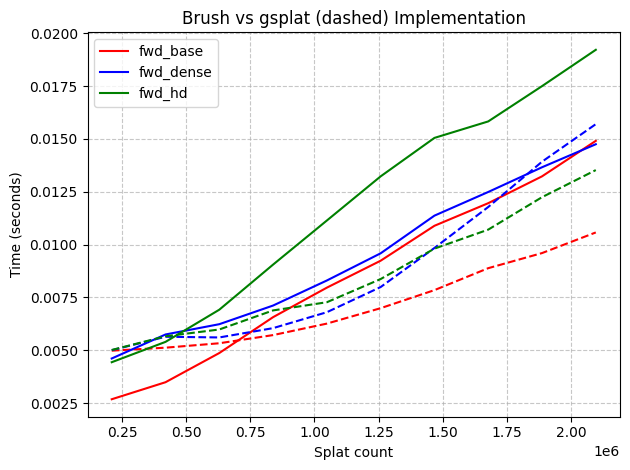

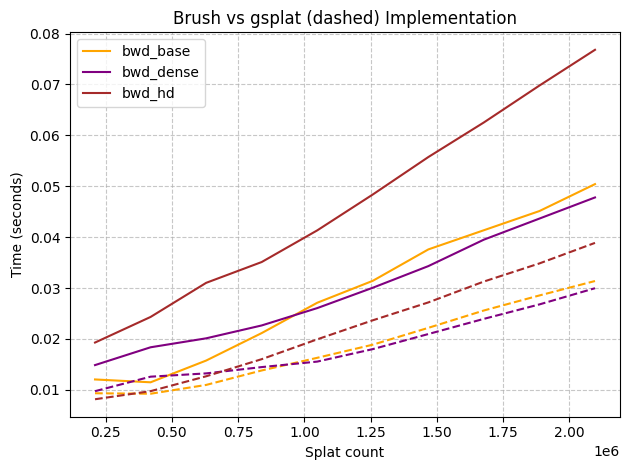

In [16]:
for bench_type in ['fwd', 'bwd']:
    # Colors for each type of line
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    # Plot lines
    for key, color in zip(bench_times.keys(), colors):
        if not bench_type in key:
            continue
        rust_values = rust_times[key]
        python_values = bench_times[key]

        counts = np.array(BENCH_DENSITIES) * (2 ** 21)

        plt.plot(counts, np.array(rust_values) / 1000.0, label=key, color=color, linestyle='-') 
        plt.plot(counts, np.array(python_values), color=color, linestyle='--')

    # Customize the plot
    plt.xlabel('Splat count')
    plt.ylabel('Time (seconds)')
    plt.title('Brush vs gsplat (dashed) Implementation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    legend1 = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().add_artist(legend1)
    plt.legend(loc='upper left') 

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()